# Final Project
## CSU CS-440 Introduction to Artificail Intelligence


Shashank Satyanarayana

shashank2710@gmail.com

## Introduction
This is the Final Project for CSU CS-440, Introduction to Artifical Intelligence. In this project, a humble effort has been made to explore and understand the nature of Convolutional Neural Networks(CNN). This project has been pursued under 3 main objectives: 
* In Section 1, we explore the various parameters of CNN and train a simple CNN using the MNIST Database
* In Section 2, we use the same CNN developed in Section 1 to train a Face Recognition Model using the ORL Database
* In Section 3, we use pre-trained VGG weights to perform video analysis. 

All experiments have been performed on a 64-bit, i7 Intel Processor system (Intel 650 Graphics), with an Ubuntu 16.04 Virtual Environment platform using Keras and Tensorflow (1.0.1) as Backend.

## Problem Space
Ever since 2012, CNN's have grown into prominence after Alex Krizhevsky used them to win the ImageNet Competition. Although Aritifical Neural Networks (ANN) have exisited since the 1960's, their use was primarily limited to training an testing 1-D data. The concept of using ANN's to train image data for classification, detectiion and recognition purposes led to the development of CNN's.
Depending on the resolution of the Image Data, a computer views the data as a vector of (nRows, nCols, 3) where the first two elements represent the number of rows and columns in an image and the third element contains the RBG/colour/gray scale information. To convert a 2D data into a 1 D vector, we perform convolution. [Image Credits](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)

<img src="https://adeshpande3.github.io/assets/Corgi3.png">

`Convolution` is best explained as a (nxn) window (commonly refered to as a `Filter`), where n is always less than the size of the image. The convolution filter is an array of numbers (commonly refered to as `Weights`), and the area of the image covered by the convolution filter is called the `Receptive Field`. As the filter slides over the image, elementwise multiplication is performed and their sum is stored. The corresponding map that is generated is known as `Activation Map` or `Feature Map`. 

For example, if a 32x32 image is subject to a 5x5 convolution filter, a 28x28 array of numbers / Activation Map will be generated as shown in the figure below. [Image Credits](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)

<img src="https://adeshpande3.github.io/assets/ActivationMap.png">

In [1]:
import numpy as np
import os
import tempfile
import cv2
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
import random

import keras
from keras import backend as K
from keras import layers

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import tensorflow as tf

Using TensorFlow backend.


## Section 1 - Understanding the Behaviour of CNN using MNIST Database

### Introduction
MNIST is a database containing the binary images of handwritten digits, developed from the NIST's Special Database 3 and Special Database 1. It is a subset of the larger NIST databse and contains 60,000 training set examples and 10,000 test set examples. More information about the MNIST database can be found [here](http://yann.lecun.com/exdb/mnist/)

### Define Network Parameters
In Neural Network Terminology:
* One Epoch = one forward pass and one backward pass of all training examples
* Batch Size = The number of training examples in one forward/backward pass
* Number of Iterations = Number of passes (one pass = one forward pass + one backward pass), with each pass using Batch Size number of examples

In [8]:
batchSize = 128
numClasses = 10
epochs = 10

### Data Acquisition and Formatting 
Due to the computational challenges faced for this project, we select only every alternate image from the database. For this section our Train Data set will have 30,000 images while the Test Data set will have 5,000 images.

In [9]:
(xTrainData, yTrainData), (xTestData, yTestData) = mnist.load_data()

In [10]:
xTrainData.shape, xTestData.shape,yTrainData.shape, yTestData.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [11]:
Xtrain=xTrainData[::2]
Xtest=xTestData[::2]
Ytest=yTestData[::2]
Ytrain=yTrainData[::2]

Xtrain.shape,Xtest.shape,Ytrain.shape, Ytest.shape

((30000, 28, 28), (5000, 28, 28), (30000,), (5000,))

### Convert 2D Image to 1D Vector

In [12]:
imageRows, imageCols = 28, 28

In [13]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], imageRows, imageCols, 1)
Xtest = Xtest.reshape(Xtest.shape[0], imageRows,imageCols, 1)
inputShape = (imageRows,imageCols,1)
Xtrain = Xtrain.astype('float32')
Xtest = Xtest.astype('float32')
Xtrain /= 255
Xtest /= 255

In [14]:
Ytrain = keras.utils.to_categorical(Ytrain, numClasses)
Ytest = keras.utils.to_categorical(Ytest, numClasses)

### Define CNN Model and summarize
This section gives a brief Introduction about the various layers of a CNN
#### First Layer
In a high level perspective, the First Layer of a CNN basically acts as `Feature Identifier`. Individual filters help identify simple features such as edges, curves, colours, Gaussian Kernels etc. 

#### MaxPooling
Max pooling is basically a sample-based discretization process, where the objective is to downsample an input data (image, convolution filter, hidden-layer etc.) while reducing dimensionality and ensuring that the features contained in the eliminated regions can actually be binned. This is usually achieved by applying a `Max Filter` to a non-overlapping subregions of the initially represented region. 

#### Dropout Layer
Dropout is a highly effecient regularisation technique to prevent overfitting of CNN. [This research publication](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) explains the importance of Dropout in a CNN. 
Dropout is achieved during training by basically deactivating half the neurons. This imporves generalisation and forces the neurons the current layer to learn the "Same Concept", but from different neurons. During prediction phase, the dropouts are deactivated. This enchances the overall performance of the network. 

#### Fully Connected
The Fully Connected (FC) layer is the last layer of the CNN.This layer basically takes an input volume from the layer preceeding it and outputs an N-dimensional output vector, where N is the number of classes. Each number in the resulting ouput vector represents the probablity of a certain class. This FC layer genereally uses a `Softmax Function`, which reduces the output of each unit to be between 0 and 1, with a sum of 1, just like the `Sigmoid Function`(Sigmoid Function can only handle two classes). 

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=inputShape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numClasses, activation='softmax'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [17]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

### Train Model

In [ ]:
history=model.fit(Xtrain, Ytrain,batch_size=batchSize,epochs=epochs,verbose=1,validation_data=(Xtest, Ytest))

In [ ]:
# Plot Model Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot Model  Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Case 1 - Study of Batch Size
In this section we study the effects of varying Batch Size on a CNN. For this experiment, I have considered Batch Sizes of 8, 16, 32, 64, 128. 

In [18]:
batchData=[]
for i in range (3,8):
    batchSize=2**i
    epochs=10 #Constant Epochs
    print('Testing MNIST Data with Batch Size={}, Epochs={}'.format(batchSize,epochs))
    # Define Model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=inputShape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    
    #Compile Model
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

    #Train Model
    history=model.fit(Xtrain, Ytrain,batch_size=batchSize,epochs=epochs,verbose=1,validation_data=(Xtest, Ytest))
    batchData.append(history.history)
    print()
    print()

Testing MNIST Data with Batch Size=8, Epochs=10
Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 426s - loss: 0.3447 - acc: 0.8943 - val_loss: 0.0966 - val_acc: 0.9660
Epoch 2/10
30000/30000 [==============================] - 428s - loss: 0.1592 - acc: 0.9529 - val_loss: 0.0705 - val_acc: 0.9764
Epoch 3/10
30000/30000 [==============================] - 433s - loss: 0.1274 - acc: 0.9615 - val_loss: 0.0737 - val_acc: 0.9764
Epoch 4/10
30000/30000 [==============================] - 418s - loss: 0.1160 - acc: 0.9653 - val_loss: 0.0572 - val_acc: 0.9822
Epoch 5/10
30000/30000 [==============================] - 420s - loss: 0.1108 - acc: 0.9677 - val_loss: 0.0547 - val_acc: 0.9830
Epoch 6/10
30000/30000 [==============================] - 436s - loss: 0.1092 - acc: 0.9686 - val_loss: 0.0573 - val_acc: 0.9826
Epoch 7/10
30000/30000 [==============================] - 441s - loss: 0.1076 - acc: 0.9688 - val_loss: 0.0484 - val_acc: 0.9840


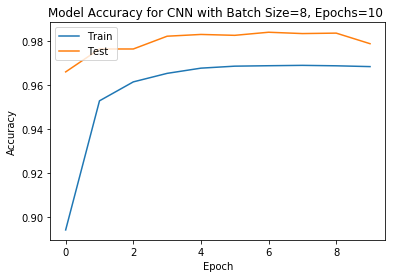

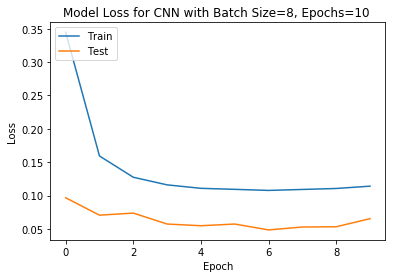

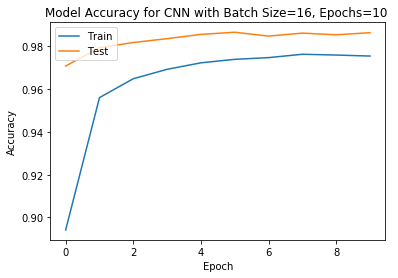

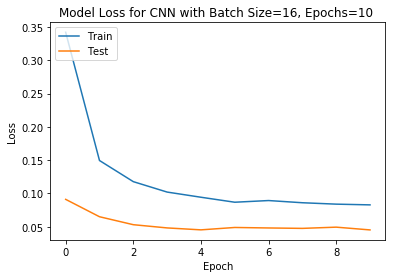

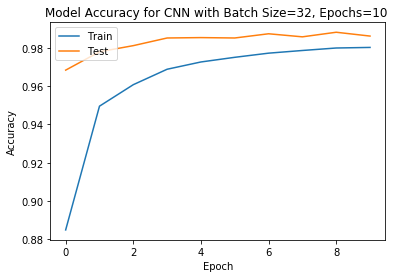

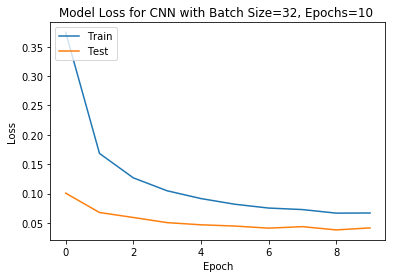

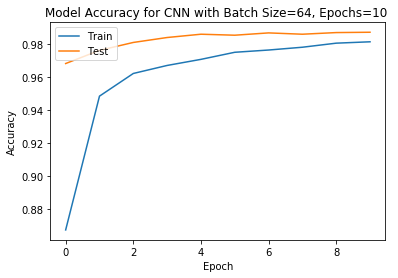

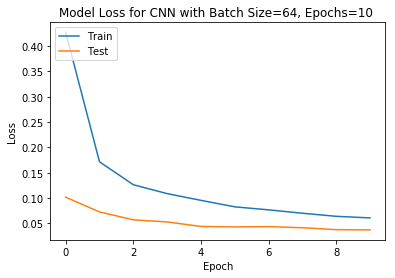

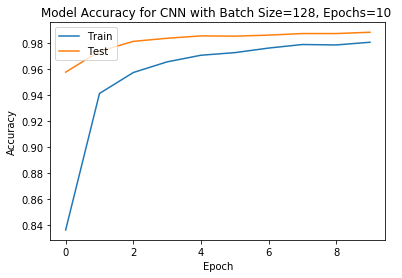

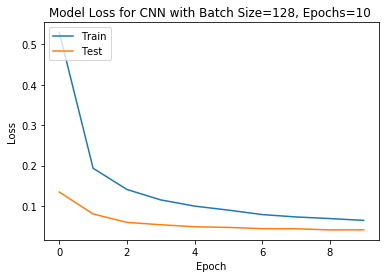

In [19]:
count=0
for i in range (3,8):
    batchSize=2**i
    epochs=10 #Constant Epochs
    # Plot Model Accuracy
    plt.plot(batchData[count]['acc'])
    plt.plot(batchData[count]['val_acc'])
    plt.title('Model Accuracy for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot Model  Loss
    plt.plot(batchData[count]['loss'])
    plt.plot(batchData[count]['val_loss'])
    plt.title('Model Loss for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    count+=1

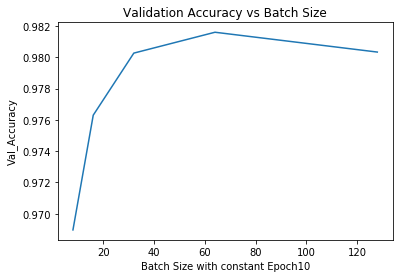

In [121]:
maxBatch=[]
for i in range (0,5):
    maxBatch.append(max(batchData[i]['acc']))

batchSize=[8,16,32,64,128]
plt.plot(batchSize,maxBatch)
plt.title('Validation Accuracy vs Batch Size')
plt.ylabel('Val_Accuracy')
plt.xlabel('Batch Size with constant Epoch10')
plt.show()

### Performance Evaluation
The following observations can be made from this experiment:
* Smaller Batch size, intuitively implies lesser memory requirements
* Smaller Batch size however considerably increases the training time of the network
* Smaller Batch size implies more gradient updates per epoch. 

Future Scope:
* With further experimentation , it maybe analysed if increasing epoch count has a comparable effect on decreasing batch size in a long run. 
* Since most CNN's take atleast 100 epochs to converge and this experiment uses only 10 epochs, there is no comprehensive way of explaining the effects of batch size on epochs



### Case 2 - Study of Epochs
In this section we study the effects of varying Epochs on a CNN. For this experiment, I have considered Epoch Sizes of 5,10,15,20

Train on 30000 samples, validate on 5000 samples
Epoch 1/5
30000/30000 [==============================] - 134s - loss: 0.0481 - acc: 0.9876 - val_loss: 0.0472 - val_acc: 0.9886
Epoch 2/5
30000/30000 [==============================] - 135s - loss: 0.0437 - acc: 0.9883 - val_loss: 0.0439 - val_acc: 0.9892
Epoch 3/5
30000/30000 [==============================] - 136s - loss: 0.0442 - acc: 0.9881 - val_loss: 0.0437 - val_acc: 0.9904
Epoch 4/5
30000/30000 [==============================] - 135s - loss: 0.0413 - acc: 0.9877 - val_loss: 0.0454 - val_acc: 0.9892
Epoch 5/5
30000/30000 [==============================] - 136s - loss: 0.0415 - acc: 0.9879 - val_loss: 0.0498 - val_acc: 0.9898


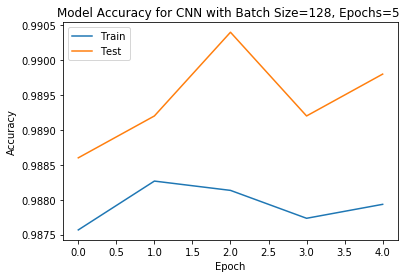

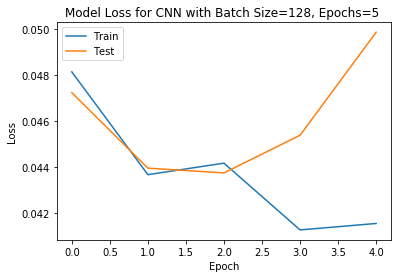

Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 137s - loss: 0.0410 - acc: 0.9887 - val_loss: 0.0510 - val_acc: 0.9888
Epoch 2/10
30000/30000 [==============================] - 136s - loss: 0.0407 - acc: 0.9888 - val_loss: 0.0433 - val_acc: 0.9900
Epoch 3/10
30000/30000 [==============================] - 136s - loss: 0.0402 - acc: 0.9888 - val_loss: 0.0463 - val_acc: 0.9886
Epoch 4/10
30000/30000 [==============================] - 137s - loss: 0.0389 - acc: 0.9884 - val_loss: 0.0421 - val_acc: 0.9888
Epoch 5/10
30000/30000 [==============================] - 138s - loss: 0.0391 - acc: 0.9888 - val_loss: 0.0454 - val_acc: 0.9884
Epoch 6/10
30000/30000 [==============================] - 136s - loss: 0.0406 - acc: 0.9887 - val_loss: 0.0414 - val_acc: 0.9896
Epoch 7/10
30000/30000 [==============================] - 134s - loss: 0.0384 - acc: 0.9885 - val_loss: 0.0506 - val_acc: 0.9884
Epoch 8/10
30000/30000 [========================

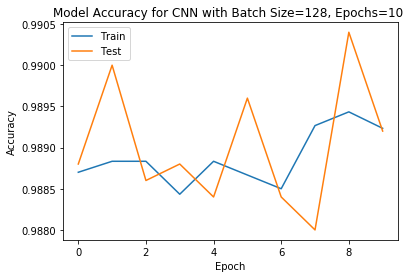

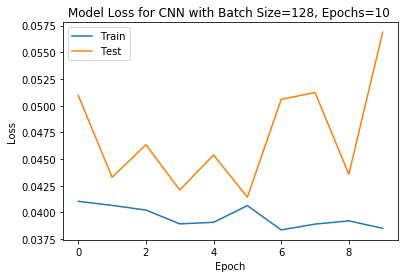

Train on 30000 samples, validate on 5000 samples
Epoch 1/15
30000/30000 [==============================] - 140s - loss: 0.0419 - acc: 0.9885 - val_loss: 0.0487 - val_acc: 0.9892
Epoch 2/15
30000/30000 [==============================] - 137s - loss: 0.0388 - acc: 0.9897 - val_loss: 0.0452 - val_acc: 0.9896
Epoch 3/15
30000/30000 [==============================] - 148s - loss: 0.0348 - acc: 0.9901 - val_loss: 0.0485 - val_acc: 0.9884
Epoch 4/15
30000/30000 [==============================] - 148s - loss: 0.0335 - acc: 0.9909 - val_loss: 0.0499 - val_acc: 0.9894
Epoch 5/15
30000/30000 [==============================] - 136s - loss: 0.0364 - acc: 0.9891 - val_loss: 0.0435 - val_acc: 0.9890
Epoch 6/15
30000/30000 [==============================] - 137s - loss: 0.0356 - acc: 0.9898 - val_loss: 0.0637 - val_acc: 0.9876
Epoch 7/15
30000/30000 [==============================] - 136s - loss: 0.0350 - acc: 0.9900 - val_loss: 0.0531 - val_acc: 0.9886
Epoch 8/15
30000/30000 [========================

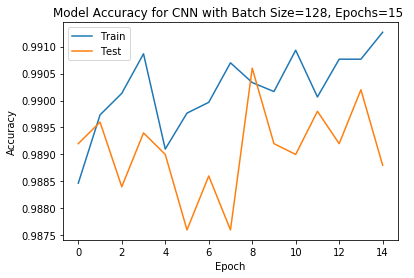

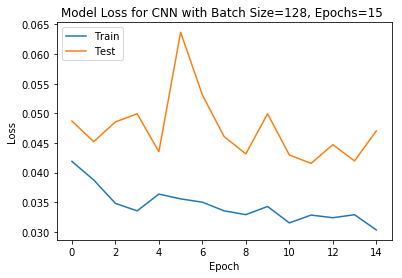

Train on 30000 samples, validate on 5000 samples
Epoch 1/20
30000/30000 [==============================] - 149s - loss: 0.0329 - acc: 0.9901 - val_loss: 0.0418 - val_acc: 0.9906
Epoch 2/20
30000/30000 [==============================] - 158s - loss: 0.0336 - acc: 0.9907 - val_loss: 0.0457 - val_acc: 0.9900
Epoch 3/20
30000/30000 [==============================] - 164s - loss: 0.0342 - acc: 0.9910 - val_loss: 0.0424 - val_acc: 0.9900
Epoch 4/20
30000/30000 [==============================] - 142s - loss: 0.0298 - acc: 0.9916 - val_loss: 0.0417 - val_acc: 0.9912
Epoch 5/20
30000/30000 [==============================] - 160s - loss: 0.0305 - acc: 0.9909 - val_loss: 0.0470 - val_acc: 0.9890
Epoch 6/20
30000/30000 [==============================] - 211s - loss: 0.0333 - acc: 0.9905 - val_loss: 0.0425 - val_acc: 0.9896
Epoch 7/20
30000/30000 [==============================] - 197s - loss: 0.0306 - acc: 0.9906 - val_loss: 0.0456 - val_acc: 0.9886
Epoch 8/20
30000/30000 [========================

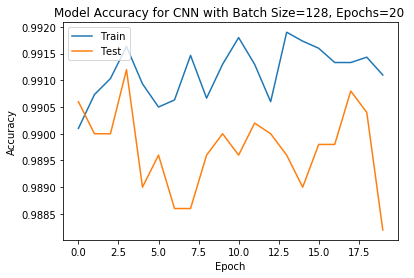

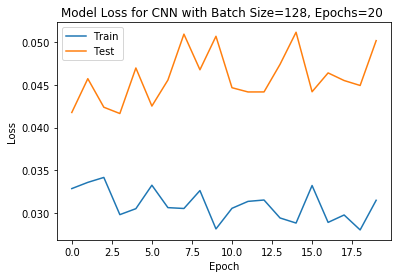

In [15]:
epochData=[]
for i in range (5,21,5):
    batchSize=128
    epochs=i #Constant Epochs
    history=model.fit(Xtrain, Ytrain,batch_size=batchSize,epochs=epochs,verbose=1,validation_data=(Xtest, Ytest))
    epochData.append(history.history)
    # Plot Model Accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot Model  Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Performance Evaluation
Intuitively, higher number of Epochs lead to better results. However the learning rate of a CNN can be modelled as follows: 

[Image Credits](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)



<img src="https://adeshpande3.github.io/assets/Loss.png">

This must explain the reason for the shape of our graphs. Additionaly, it may be observed that the CNN with 15 Epochs has a Test Accuracy of 0.9913, while the CNN with 20 Epochs has a Test Accuracy of 0.9911.

Future Work:
* `Early Stopping`: Divide data in three data sets, training, validation and evaluation. Train each network along a sufficient number of epochs to see the training Mean Squared Error to be stuck in a minimum. The training process uses training data-set and must be executed epoch by epoch, in order to calculate the Mean Squared Error of the network in each epoch for the validation set. The network for the epoch with the minimum validation MSE is selected for the evaluation process.
* Additionaly Regularisation Methods and K-Fold Cross Validation maybe applied in conjugation with Early Stopping

### Case 3 - Study of Dropout Layers
In this section, we study the effects of Dropout Layers. Previously generated models in Case 1 and 2 use two `Dropout Layers`. In this section, a simple experiment is performened where the two `Dropout Layers` are interchanged. 

In [36]:
batchSize = 128
numClasses = 10
epochs = 10

#### Model 1

In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=inputShape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numClasses, activation='softmax'))

#Model Summary
model.summary()

#Model Compile
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [28]:
droupoutData=[]
history=model.fit(Xtrain, Ytrain,batch_size=batchSize,epochs=epochs,verbose=1,validation_data=(Xtest, Ytest))
droupoutData.append(history.history)

Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 159s - loss: 0.3550 - acc: 0.8909 - val_loss: 0.1251 - val_acc: 0.9588
Epoch 2/10
30000/30000 [==============================] - 163s - loss: 0.1802 - acc: 0.9448 - val_loss: 0.0725 - val_acc: 0.9768
Epoch 3/10
30000/30000 [==============================] - 165s - loss: 0.1306 - acc: 0.9613 - val_loss: 0.0601 - val_acc: 0.9820
Epoch 4/10
30000/30000 [==============================] - 151s - loss: 0.1118 - acc: 0.9650 - val_loss: 0.0537 - val_acc: 0.9824
Epoch 5/10
30000/30000 [==============================] - 154s - loss: 0.0961 - acc: 0.9711 - val_loss: 0.0488 - val_acc: 0.9852
Epoch 6/10
30000/30000 [==============================] - 149s - loss: 0.0881 - acc: 0.9735 - val_loss: 0.0485 - val_acc: 0.9846
Epoch 7/10
30000/30000 [==============================] - 169s - loss: 0.0783 - acc: 0.9754 - val_loss: 0.0453 - val_acc: 0.9860
Epoch 8/10
30000/30000 [========================

#### Model 2

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=inputShape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(numClasses, activation='softmax'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
__________

In [39]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [40]:
history=model.fit(Xtrain, Ytrain,batch_size=batchSize,epochs=epochs,verbose=1,validation_data=(Xtest, Ytest))
droupoutData.append(history.history)


Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 160s - loss: 0.4618 - acc: 0.8564 - val_loss: 0.1280 - val_acc: 0.9612
Epoch 2/10
30000/30000 [==============================] - 154s - loss: 0.1656 - acc: 0.9481 - val_loss: 0.0781 - val_acc: 0.9754
Epoch 3/10
30000/30000 [==============================] - 163s - loss: 0.1196 - acc: 0.9628 - val_loss: 0.0571 - val_acc: 0.9818
Epoch 4/10
30000/30000 [==============================] - 156s - loss: 0.0996 - acc: 0.9684 - val_loss: 0.0503 - val_acc: 0.9842
Epoch 5/10
30000/30000 [==============================] - 139s - loss: 0.0875 - acc: 0.9725 - val_loss: 0.0530 - val_acc: 0.9826
Epoch 6/10
30000/30000 [==============================] - 137s - loss: 0.0813 - acc: 0.9744 - val_loss: 0.0451 - val_acc: 0.9868
Epoch 7/10
30000/30000 [==============================] - 139s - loss: 0.0691 - acc: 0.9788 - val_loss: 0.0400 - val_acc: 0.9866
Epoch 8/10
30000/30000 [========================

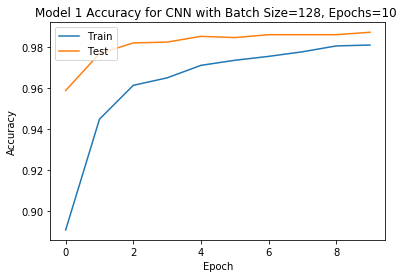

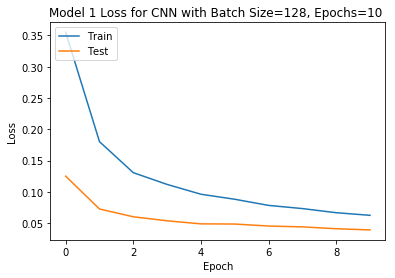

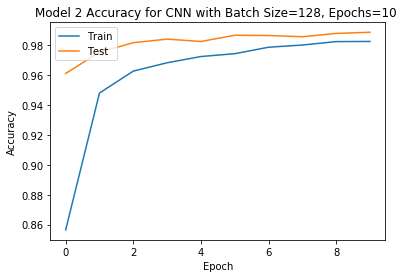

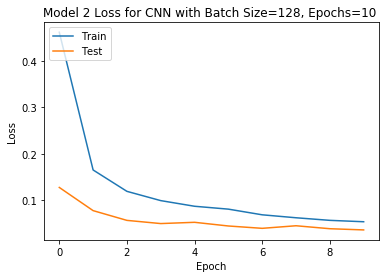

In [47]:
for i in range (0,2):
    batchSize = 128
    epochs = 10
    # Plot Model Accuracy
    plt.plot(droupoutData[i]['acc'])
    plt.plot(droupoutData[i]['val_acc'])
    plt.title('Model {} Accuracy for CNN with Batch Size={}, Epochs={} '.format(i+1,batchSize,epochs))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot Model  Loss
    plt.plot(droupoutData[i]['loss'])
    plt.plot(droupoutData[i]['val_loss'])
    plt.title('Model {} Loss for CNN with Batch Size={}, Epochs={} '.format(i+1,batchSize,epochs))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [119]:
print ('Model 1 Train Data Accuracy {}'.format(np.mean(droupoutData[0]['acc'])*100))
print ('Model 2 Train Data Accuracy {}'.format(np.mean(droupoutData[1]['acc'])*100))
print ('Model 1 Validation Data Accuracy {}'.format(np.mean(droupoutData[1]['val_acc'])*100))
print ('Model 2 Validation Data Accuracy {}'.format(np.mean(droupoutData[0]['val_acc'])*100))

Model 1 Train Data Accuracy 96.2119999994
Model 2 Train Data Accuracy 96.0676666673
Model 1 Validation Data Accuracy 98.212
Model 2 Validation Data Accuracy 98.15


### Performance Evaluation
Dropout layers were implemented using a simple function. The average Accuracy of the Train and Validation data are given above and following conclusion may be derived from this experiment:
* A high value Dropout layer after the initial layer decreases the accuracy of the system since the first layer of the CNN is generally dedicated to learning Features

#### Future Work
* Effects of Dropout on Large network v/s Small Network
* Effects of predecessor layer on the Dropout Layer. Does increasing learning rate in the previous layer effect the presence of Dropout Layer

## Section 2 - Developing a Face Recognition System using ORL Database
### Introduction
In this section, we use the [ORL Face Image Database](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html), produced by the Cambridge University Engineering Department. There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). 
### Note: 
An honest attempt was made to train a CNN using ORL database. However, the accuracy achieved was not very impressive. Addtionally, the CNN did not perform well for the `Study of Batch Size` and most of the results could not be scientifically explained 

In [96]:
DatasetPath = []
for i in os.listdir("orl"):
    DatasetPath.append(os.path.join("orl", i))

In [97]:
DataPath=sorted(DatasetPath)

In [98]:
len(DataPath)

400

In [99]:
imageData = []
imageLabels = []
imageClass=0
count=-1
for i in DataPath:
    imgRead = io.imread(i,as_grey=True)
    imageData.append(imgRead)
    if count==9:
        imageClass+=1
        count=0
    else:
        count+=1
    imageLabels.append(imageClass)

In [100]:
np.array(imageData).shape

(400, 112, 92)

In [101]:
np.array(imageLabels).shape

(400,)

### Opencv Pre-Processing

To pre-process the ORL data, we used OpenCV 3.1. The `HaarCascade` for frontal face was used to detect the face, before cropping it to the size of 112 x 92 pixels

In [ ]:
imageDataFace = []
faceDetectClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
for i in imageData:
    facePoints = faceDetectClassifier.detectMultiScale(i)
    x,y = facePoints[0][:2]
    cropped = i[y: y + 115, x: x + 92]
    imageDataFace.append(cropped)

### Split Dataset
We randomly split the data in the ratio of Train:Test of 80:20

In [102]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(np.array(imageData),np.array(imageLabels), train_size=0.8, random_state=30)
np.array(Xtrain).shape, np.array(Xtest).shape


((320, 112, 92), (80, 112, 92))

In [103]:
batchSize=64
numClasses=40
epochs=20
imageRows, imageCols =112,92

In [104]:
Ytrain = keras.utils.to_categorical(Ytrain, numClasses)
Ytest = keras.utils.to_categorical(Ytest, numClasses)

### Covert 2D image to a 1D vector

In [105]:
Xtrain = Xtrain.reshape(Xtrain.shape[0], imageRows, imageCols, 1)
Xtest = Xtest.reshape(Xtest.shape[0], imageRows,imageCols, 1)
inputShape = (imageRows,imageCols,1)
Xtrain = Xtrain.astype('float32')
Xtest = Xtest.astype('float32')
Xtrain /= 255
Xtest /= 255

In [106]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=inputShape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numClasses, activation='softmax'))

In [107]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 110, 90, 32)       320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 108, 88, 64)       18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 44, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 54, 44, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 152064)            0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               19464320  
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
__________

### Model Train

In [62]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])

In [81]:
imageTrainData=model.fit(Xtrain, Ytrain,batch_size=batchSize,epochs=epochs,verbose=1,validation_data=(Xtest, Ytest))

Train on 320 samples, validate on 80 samples
Epoch 1/20
320/320 [==============================] - 25s - loss: 3.5627 - acc: 0.0469 - val_loss: 3.6123 - val_acc: 0.0250
Epoch 2/20
320/320 [==============================] - 38s - loss: 3.5525 - acc: 0.0344 - val_loss: 3.6268 - val_acc: 0.0625
Epoch 3/20
320/320 [==============================] - 25s - loss: 3.5306 - acc: 0.0625 - val_loss: 3.6044 - val_acc: 0.0625
Epoch 4/20
320/320 [==============================] - 24s - loss: 3.5401 - acc: 0.0563 - val_loss: 3.5751 - val_acc: 0.0375
Epoch 5/20
320/320 [==============================] - 25s - loss: 3.5100 - acc: 0.0563 - val_loss: 3.5563 - val_acc: 0.0500
Epoch 6/20
320/320 [==============================] - 26s - loss: 3.4756 - acc: 0.0625 - val_loss: 3.6242 - val_acc: 0.0500
Epoch 7/20
320/320 [==============================] - 25s - loss: 3.5088 - acc: 0.0563 - val_loss: 3.5571 - val_acc: 0.0500
Epoch 8/20
320/320 [==============================] - 24s - loss: 3.4607 - acc: 0.0625 

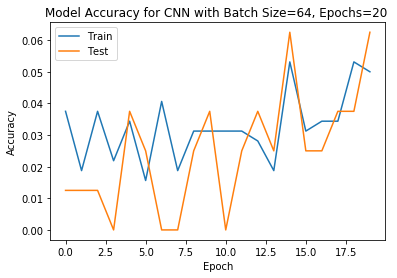

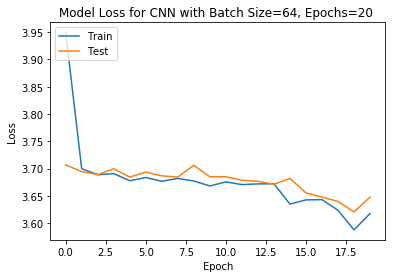

In [80]:
plt.plot(imageTrainData.history['acc'])
plt.plot(imageTrainData.history['val_acc'])
plt.title('Model Accuracy for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot Model  Loss
plt.plot(imageTrainData.history['loss'])
plt.plot(imageTrainData.history['val_loss'])
plt.title('Model Loss for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Case 1 - Study of Batch Size

In [108]:
imageBatchData=[]
for i in range (3,8):
    batchSize=2**i
    epochs=20 #Constant Epochs
    
    print('Testing ORL Data with Batch Size={}, Epochs={}'.format(batchSize,epochs))
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=inputShape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numClasses, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
    
    history=model.fit(Xtrain, Ytrain,batch_size=batchSize,epochs=epochs,verbose=1,validation_data=(Xtest, Ytest))
    imageBatchData.append(history.history)
    print()
    print()

Testing ORL Data with Batch Size=8, Epochs=20
Train on 320 samples, validate on 80 samples
Epoch 1/20
320/320 [==============================] - 47s - loss: 3.7507 - acc: 0.0375 - val_loss: 3.6703 - val_acc: 0.0750
Epoch 2/20
320/320 [==============================] - 39s - loss: 3.6380 - acc: 0.0562 - val_loss: 3.6097 - val_acc: 0.1750
Epoch 3/20
320/320 [==============================] - 52s - loss: 3.4811 - acc: 0.1250 - val_loss: 3.4143 - val_acc: 0.1500
Epoch 4/20
320/320 [==============================] - 44s - loss: 3.0595 - acc: 0.2156 - val_loss: 3.0075 - val_acc: 0.2750
Epoch 5/20
320/320 [==============================] - 47s - loss: 2.5700 - acc: 0.3187 - val_loss: 2.4521 - val_acc: 0.3250
Epoch 6/20
320/320 [==============================] - 49s - loss: 1.9673 - acc: 0.5188 - val_loss: 2.1592 - val_acc: 0.4875
Epoch 7/20
320/320 [==============================] - 47s - loss: 1.5148 - acc: 0.5969 - val_loss: 1.8262 - val_acc: 0.5625
Epoch 8/20
320/320 [=====================

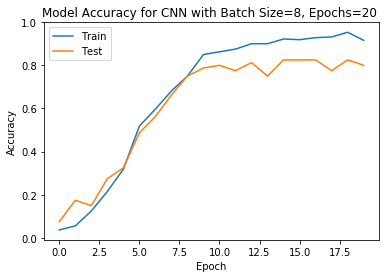

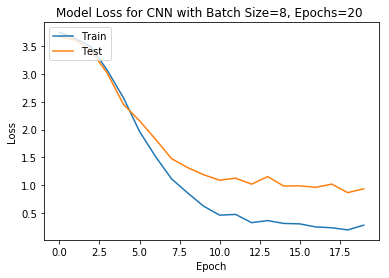

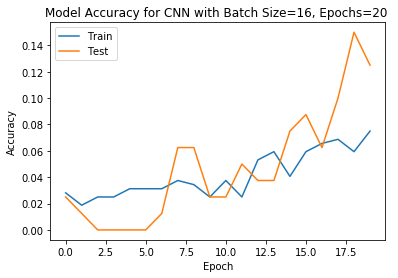

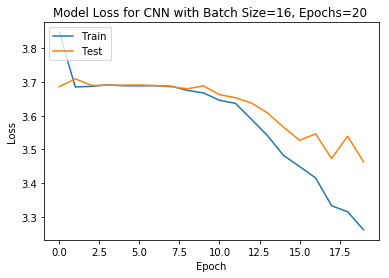

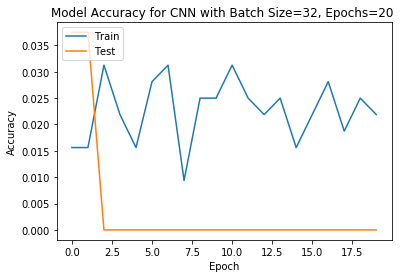

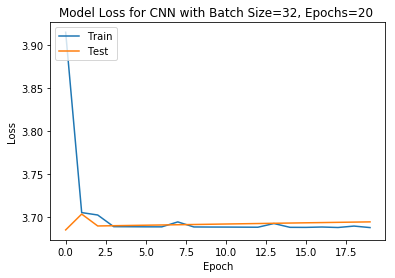

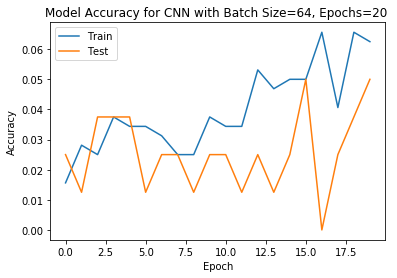

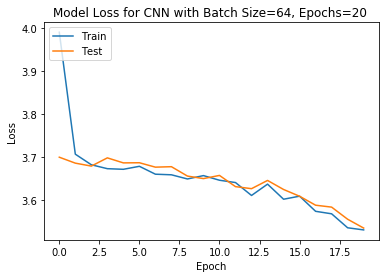

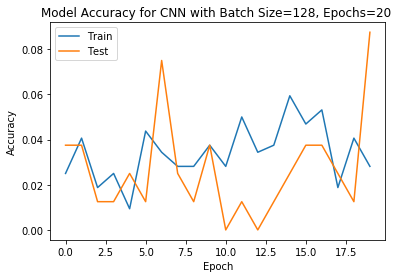

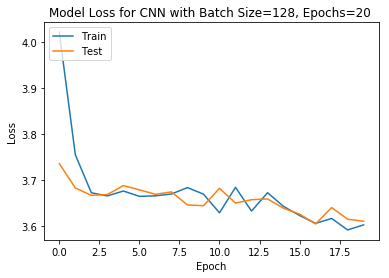

In [110]:
count=0
for i in range (3,8):
    batchSize=2**i
    epochs=20 #Constant Epochs
    # Plot Model Accuracy
    plt.plot(imageBatchData[count]['acc'])
    plt.plot(imageBatchData[count]['val_acc'])
    plt.title('Model Accuracy for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # Plot Model  Loss
    plt.plot(imageBatchData[count]['loss'])
    plt.plot(imageBatchData[count]['val_loss'])
    plt.title('Model Loss for CNN with Batch Size={}, Epochs={} '.format(batchSize,epochs))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    count+=1

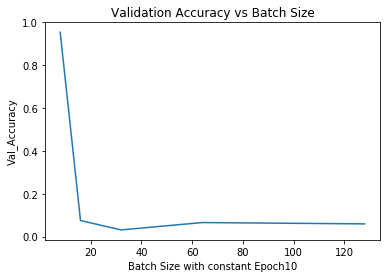

In [120]:
maxImageBatch=[]
for i in range (0,5):
    maxImageBatch.append(max(imageBatchData[i]['acc']))

batchSize=[8,16,32,64,128]
plt.plot(batchSize,maxImageBatch)
plt.title('Validation Accuracy vs Batch Size')
plt.ylabel('Val_Accuracy')
plt.xlabel('Batch Size with constant Epoch10')
plt.show()

### Performance Evaluation
Unfortunately, the given network did not perform well for this experiment and the results could not be scientifically explained

## Section 3 - Video Processing using VGG-16 

In this section we aim to perform Video Processing using VGG 16 network. For this, we use the code of VGG 16 implementation on python from [here](https://www.cs.colostate.edu/~cs510/yr2017sp/more_assignments/vgg.zip) and then implement the following algorithm using OpenCV

Algorithm:
* Convert the Image to Grayscale
* Apply Gaussian filter to remove noise
* Apply [SIFT](https://docs.opencv.org/3.3.0/da/df5/tutorial_py_sift_intro.html) to determine a Static Object with the highest Descriptor and save the image
* Apply [MOSSE Filter](https://docs.opencv.org/master/d0/d02/classcv_1_1TrackerMOSSE.html) to determine any moving object and the image of the object
* Feed the static and dynamic image to VGG for Objet Recognition after resizing the image to 224 x 224 (since input to a VGG network can only be 224 x 224)
* Note the direction of movement of the Dynamic Frame (comparing to position of previous frame) and Display Output

The output video and corresponding executable files have been attached in the folder. 
Execute `program3.py` to run the simulation.
Note about the Video:
* Blue Boxes indicate Static Objects
* Red Boxex indicate Dynamic Objects
* The command terminal provides the Prediction and Probability of the objects

## Conclusion
This project has given me an oppurtunity to explore Convolutional Neural Networks, the various components of a CNN, their working and their importance. Additionaly, this project has also given be insights about the behaviour of CNN to variations in:
* Epoch Size
* Batch Size
* Dropout Layer

Finally, I have learned to build a CNN for `Facial Recognition` and applications of CNN for real-time video processing.

## References
* Prof. Charles Anderson for his dedicated support throughout the course of this project.
* Russell and Norvig, 2014 Stuart Russell and Peter Norvig, Artificial Intelligence: [A Modern Approach](http://aima.cs.berkeley.edu/), Publisher. 2014
* [Keras](https://keras.io/)
* Dropout:  A Simple Way to Prevent Neural Networks from
Overfitting (http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)